In [1]:
from PIL import Image
import os

In [2]:
from fastai.vision.all import *
import timm
from fastai.distributed import *
import warnings
warnings.simplefilter("ignore")

In [3]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

random_seed(42, True)

In [4]:
path = r'C:/Users/ArrunPersonal/Codes/SkinDisease/Dataset'
bs = 6
sz = 224

# Define data augmentation transforms


data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(sz),
    splitter=GrandparentSplitter(train_name="train", valid_name="test"),
    batch_tfms = aug_transforms(do_flip=True, flip_vert=True, max_rotate=120.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0.3, size=sz))
#     batch_tfms = aug_transforms(mult=1.0, do_flip=True, flip_vert=True, max_rotate=120.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, size=sz, mode='bilinear', pad_mode='reflection', align_corners=True, batch=False, min_scale=1.0)
# )

In [5]:
dls = data.dataloaders(path, bs=bs)
print("Number of classes: ",dls.c)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Number of classes:  31


In [6]:
# Total number of train samples
train_samples = len(dls.train_ds)

# Total number of test samples
test_samples = len(dls.valid_ds)

print(f"Total train samples: {train_samples}")
print(f"Total test samples: {test_samples}")

Total train samples: 3916
Total test samples: 994


In [7]:
arch = "convnext_large_in22k"
model = timm.create_model(arch, pretrained=True, in_chans=3, num_classes=dls.c)
#model.head.fc = nn.Sequential(create_cls_module(nf=model.num_features, n_out=dls.c))

In [8]:
savedfilename = f'{path}_{arch}_opti_augmented'
learn = Learner(dls, model, metrics=[accuracy,Precision(average='macro'), Recall(average='macro'), F1Score(average='macro')],  cbs=[CSVLogger(fname=savedfilename+'.csv', append=True),
                         SaveModelCallback(monitor='valid_loss', comp=None, min_delta=0.0, fname=savedfilename, every_epoch=False, with_opt=False, reset_on_fit=True)])

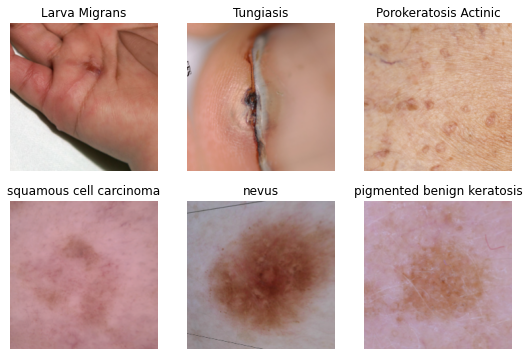

In [9]:
dls.show_batch()

In [10]:
learn.summary()

ConvNeXt (Input shape: 6)
Layer (type)         Output Shape         Param #    Trainable 
                     6 x 192 x 56 x 56   
Conv2d                                    9408       True      
LayerNorm2d                               384        True      
Identity                                                       
Conv2d                                    9600       True      
LayerNorm                                 384        True      
____________________________________________________________________________
                     6 x 56 x 56 x 768   
Linear                                    148224     True      
GELU                                                           
Dropout                                                        
____________________________________________________________________________
                     6 x 56 x 56 x 192   
Linear                                    147648     True      
Dropout                                               

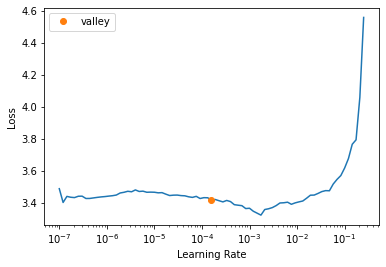

In [11]:
lr = learn.lr_find()

## Optimal Augmentation Training

In [12]:
learn.fit(30, lr)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.093964,0.981670,0.689135,0.780173,0.669676,0.690172,14:21
1,0.710863,0.763420,0.738431,0.790159,0.743990,0.744815,15:28
2,0.505099,0.623222,0.802817,0.860148,0.802215,0.816969,15:50
3,0.385749,0.634539,0.803823,0.850248,0.832298,0.827977,16:22
4,0.344515,0.646548,0.800805,0.840457,0.822630,0.818322,17:26
5,0.288359,0.743535,0.791750,0.838897,0.797718,0.804103,17:13
6,0.236531,0.690037,0.800805,0.828786,0.812753,0.811232,18:57
7,0.178039,0.554258,0.832998,0.861629,0.831632,0.840167,21:35
8,0.212602,0.621879,0.820926,0.849658,0.845199,0.839699,21:36
9,0.286756,0.725776,0.792757,0.830335,0.817025,0.811326,21:17


Better model found at epoch 0 with valid_loss value: 0.9816700220108032.
Better model found at epoch 1 with valid_loss value: 0.7634201645851135.
Better model found at epoch 2 with valid_loss value: 0.6232221126556396.
Better model found at epoch 7 with valid_loss value: 0.5542576909065247.


## New Training

In [12]:
learn.fit(30, lr)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.433319,1.309395,0.563380,0.634459,0.519736,0.522054,15:42
1,0.889333,0.975892,0.688129,0.737080,0.695020,0.686157,14:01
2,0.665935,0.776169,0.762575,0.834869,0.775667,0.785742,13:29
3,0.502979,0.761394,0.770624,0.817201,0.774864,0.780461,13:38
4,0.355929,0.758720,0.764588,0.824991,0.786951,0.782227,12:55
5,0.294867,0.606485,0.800805,0.824314,0.813537,0.812443,13:51
6,0.354375,0.766763,0.765594,0.813380,0.773170,0.779960,13:44
7,0.260336,0.864537,0.774648,0.822930,0.772532,0.778452,12:20
8,0.349662,0.954465,0.718310,0.838447,0.709084,0.733044,11:50
9,0.291044,0.659564,0.810865,0.854028,0.832940,0.832474,13:49


Better model found at epoch 0 with valid_loss value: 1.3093953132629395.
Better model found at epoch 1 with valid_loss value: 0.9758918881416321.
Better model found at epoch 2 with valid_loss value: 0.7761690616607666.
Better model found at epoch 3 with valid_loss value: 0.7613939046859741.
Better model found at epoch 4 with valid_loss value: 0.7587202787399292.
Better model found at epoch 5 with valid_loss value: 0.6064853668212891.


KeyboardInterrupt: 

## Old Training

In [ ]:
learn.fit(30, lr)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,3.008987,2.926500,0.183099,0.019972,0.067577,0.029844,10:29
1,2.320798,2.242133,0.300805,0.304748,0.205841,0.184246,13:44
2,1.463166,1.307197,0.578471,0.698480,0.556866,0.569879,16:03
3,0.855969,0.937415,0.702213,0.766285,0.694905,0.705781,16:14
4,0.512151,0.986861,0.687123,0.764279,0.673233,0.686424,17:58
5,0.340668,0.910272,0.742455,0.787616,0.738046,0.743601,17:02
6,0.211118,1.031945,0.708250,0.759367,0.730900,0.727981,23:32
7,0.210147,1.076686,0.703219,0.774242,0.694550,0.699734,27:36


Better model found at epoch 0 with valid_loss value: 2.926499843597412.
Better model found at epoch 1 with valid_loss value: 2.242133140563965.
Better model found at epoch 2 with valid_loss value: 1.307196855545044.
Better model found at epoch 3 with valid_loss value: 0.9374150633811951.
Better model found at epoch 5 with valid_loss value: 0.910271942615509.
